# Generative Adversarial Network using Adaptive Instance Normalization
## Performing on MNIST

Talk about overkill.

In [1]:
#Import packages
import numpy as np
from keras.layers import *
from keras.models import *
from keras.datasets import mnist
from keras.optimizers import RMSprop
import keras.backend as K
import matplotlib.pyplot as plt
from functools import partial

Using TensorFlow backend.


In [2]:
#Hyperparameters
batch_size = 64
iterations = 10000

#Loss tracking
d_loss = []
g_loss = []
gp_loss = []

#Import data
(x_train, _), (_, _) = mnist.load_data()

#Normalize data
x_train = np.reshape(x_train, (60000, 28, 28, 1)).astype('float32')
x_train = x_train / 255

In [3]:
def AdaIN(x):
    #Normalize x[0]
    mean = K.mean(x[0], axis = [0, 1], keepdims = True)
    std = K.std(x[0], axis = [0, 1], keepdims = True) + 1e-7
    y = (x[0] - mean) / std
    
    #Reshape gamma and beta
    pool_shape = [-1, 1, 1, y.shape[-1]]
    g = K.reshape(x[1], pool_shape)
    b = K.reshape(x[2], pool_shape)
    
    #Multiply by x[1] (GAMMA) and add x[2] (BETA)
    return y * g + b

In [4]:
def gradient_penalty_loss(y_true, y_pred, sample, weight):
    gradients = K.gradients(y_pred, sample)[0]
    gradients_sqr = K.square(gradients)
    gradient_penalty = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))

    # (weight / 2) * ||grad||^2
    # Penalize the gradient norm
    return K.mean(gradient_penalty) * (weight / 2)

In [5]:
#Build Generator network.

#Latent input
latent = Input([100])

#Mapping
w = Dense(128, activation = 'relu')(latent)
w = Dense(128, activation = 'relu')(w)

#Small image
x = Dense(7*7*64, activation = 'relu')(w)
x = Reshape([7, 7, 64])(x)

#Layer = Convolution, AdaIN, Activation
#7x7x64
gamma = Dense(32, bias_initializer = 'ones')(w)
beta = Dense(32)(w)

x = Conv2D(32, 4, padding = 'same')(x)
x = Lambda(AdaIN)([x, gamma, beta])
x = Activation('relu')(x)
x = UpSampling2D()(x)

#14x14x32
gamma = Dense(16, bias_initializer = 'ones')(w)
beta = Dense(16)(w)

x = Conv2D(16, 4, padding = 'same')(x)
x = Lambda(AdaIN)([x, gamma, beta])
x = Activation('relu')(x)
x = UpSampling2D()(x)

#28x28x16
x = Conv2D(8, 4, padding = 'same', activation = 'relu')(x)
x = Dense(1, activation = 'sigmoid')(x)

generator = Model(inputs = latent, outputs = x)

In [6]:
#Build discriminator network.
discriminator = Sequential()

#Discriminator starts with an image of shape 28x28x1.
#Use convolution and pooling to extract features and make the image smaller.
discriminator.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = [28, 28, 1]))
discriminator.add(AveragePooling2D())

#Now the image is 14x14x16. Use more convolution and pooling.
discriminator.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu'))
discriminator.add(AveragePooling2D())

#Now the image is 7x7x32. Use more convolution and flatten the image.
discriminator.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu'))
discriminator.add(Flatten())

#Now you have a vector of length 7*7*64, use fully connected networks to find your output
discriminator.add(Dense(100, activation = 'relu'))
discriminator.add(Dense(1))

#Single scalar output, which can be anything.

In [7]:
#Build network to train the discriminator.
#Discriminator will train, but Generator won't train.
for layer in discriminator.layers:
    layer.trainable = True
    
for layer in generator.layers:
    layer.trainable = False
    
    
    
#Get real image
real_image = Input([28, 28, 1])

#Discriminator classifies
validity_real = discriminator(real_image)



#Get latent input
latent_input = Input([100])

#Generate an image
fake_image = generator(latent_input)

#Discriminator classifies
validity_fake = discriminator(fake_image)

#Create and compile the model
DiscriminatorModel = Model(inputs = [real_image, latent_input], outputs = [validity_real, validity_fake, validity_real])

gp_loss_partial = partial(gradient_penalty_loss, sample = real_image, weight = 10)

DiscriminatorModel.compile(optimizer = RMSprop(lr = 0.0002), loss = ['mean_squared_error', 'mean_squared_error', gp_loss_partial])

In [8]:
#Build network to train the generator.
#Discriminator won't train, but Generator will train.
for layer in discriminator.layers:
    layer.trainable = False
    
for layer in generator.layers:
    layer.trainable = True

#Get latent input
latent_input = Input([100])

#Generate an image
fake_image = generator(latent_input)

#Discriminator classifies
validity = discriminator(fake_image)

#Create and compile the model
GeneratorModel = Model(inputs = latent_input, outputs = validity)

GeneratorModel.compile(optimizer = RMSprop(lr = 0.0002), loss = 'mean_squared_error')

In [9]:
#Train the models in a loop
for i in range(iterations):
    
    print('\rIteration ' + str(i), end = '\r')
    
    #Get labels
    real_labels = np.ones([batch_size, 1])
    fake_labels = np.zeros([batch_size, 1])
    
    #Get images and latent vectors
    image_indices = np.random.randint(0, x_train.shape[0] - 1, [batch_size])
    real_images = x_train[image_indices]
    latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 100])
    
    #Train D
    loss = DiscriminatorModel.train_on_batch([real_images, latent_vectors], [real_labels, fake_labels, real_labels])
    d_loss.append(loss[1]/2 + loss[2]/2)
    gp_loss.append(loss[3])
    
    #Get latent vectors
    latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 100])
    
    #Train G
    loss = GeneratorModel.train_on_batch(latent_vectors, real_labels)
    g_loss.append(loss)

/home/matt/.local/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/home/matt/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


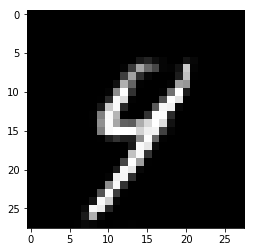

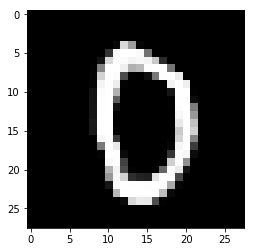

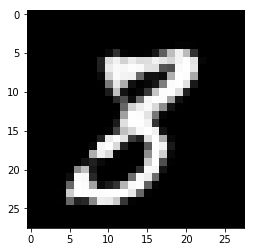

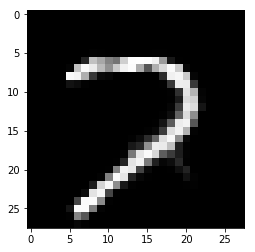

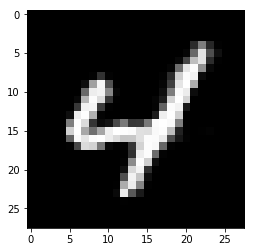

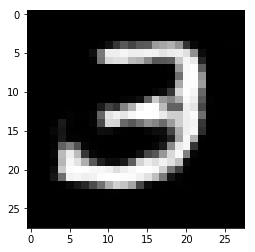

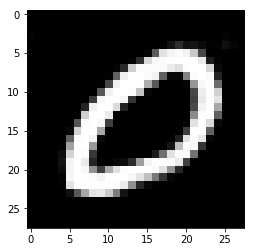

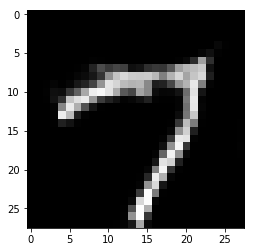

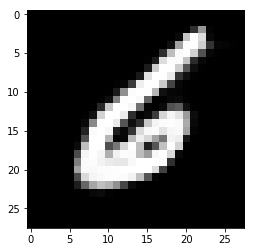

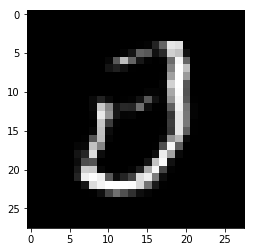

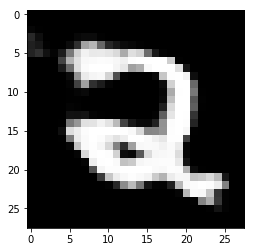

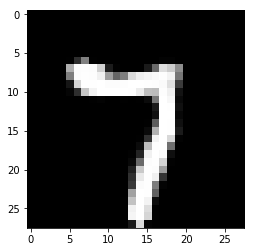

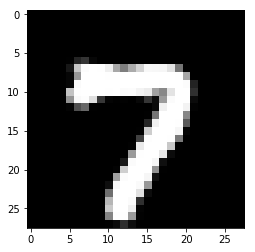

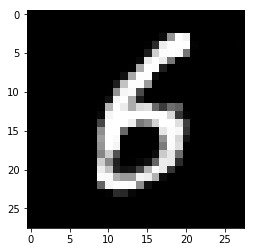

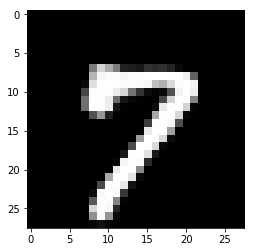

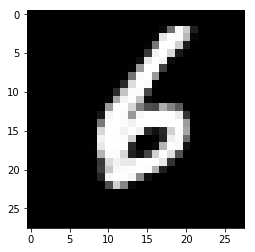

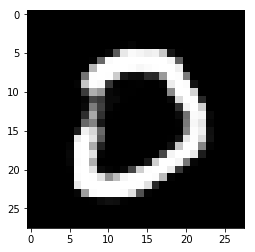

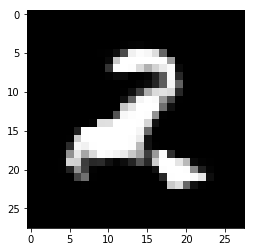

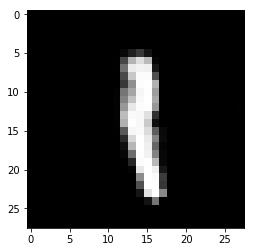

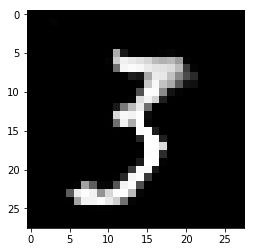

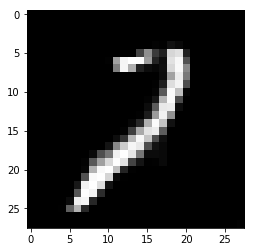

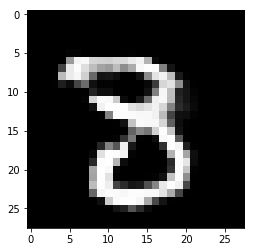

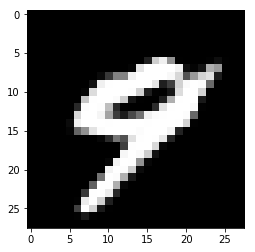

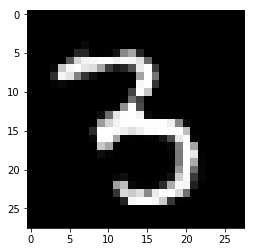

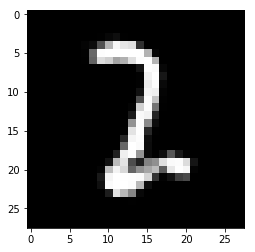

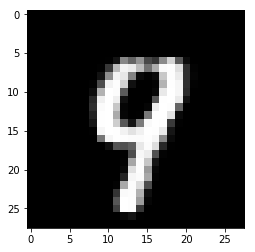

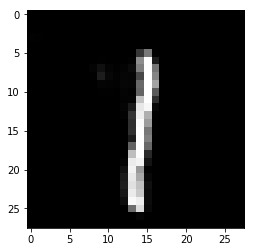

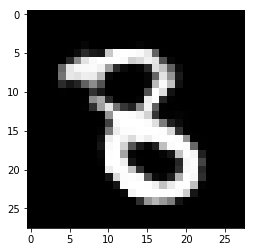

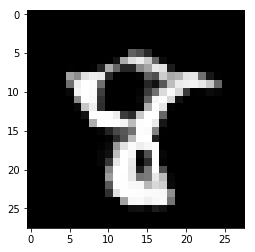

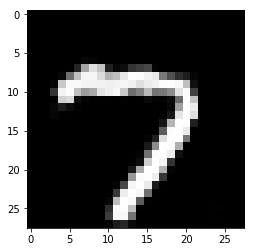

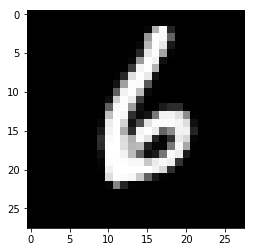

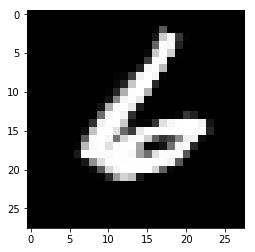

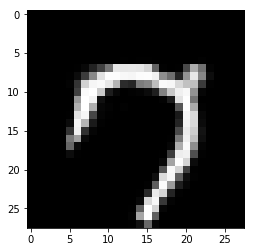

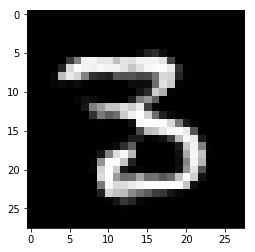

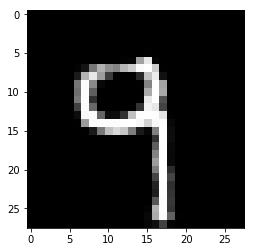

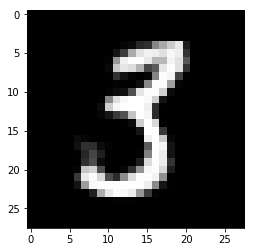

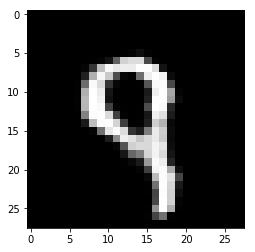

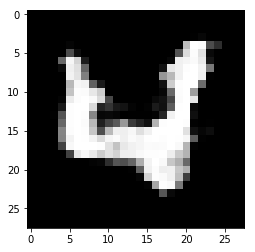

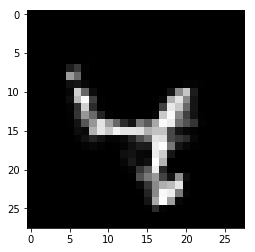

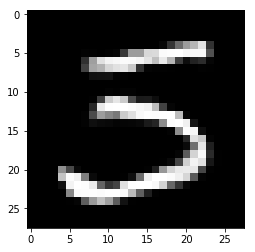

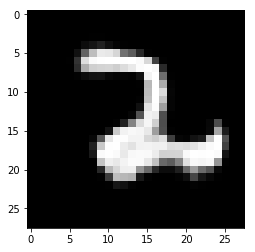

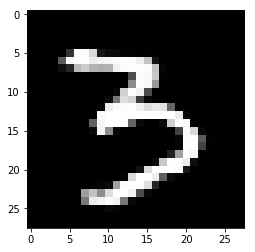

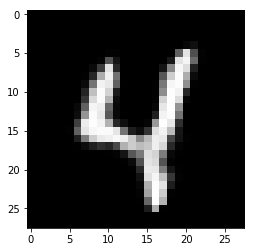

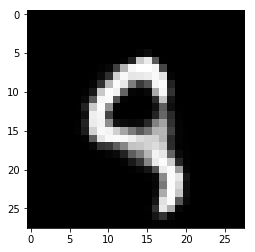

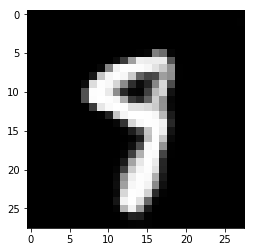

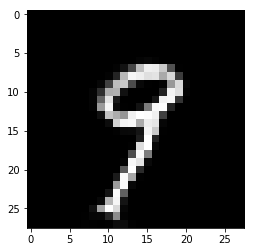

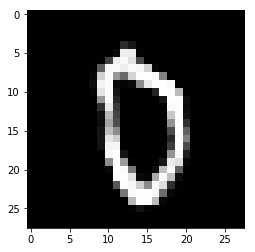

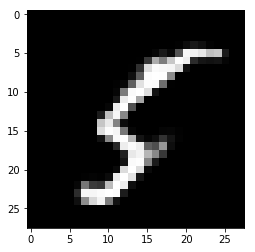

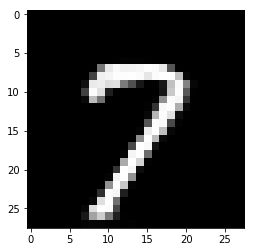

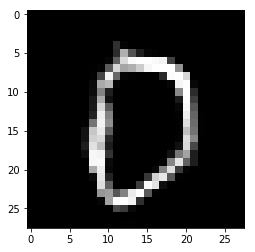

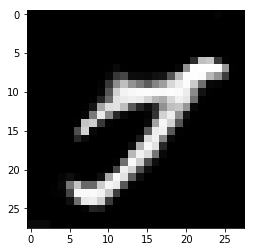

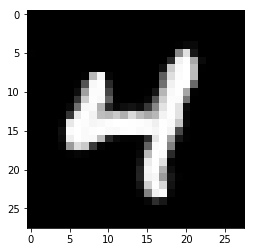

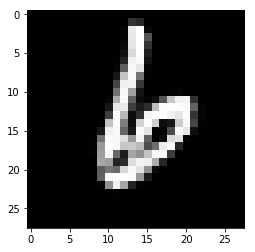

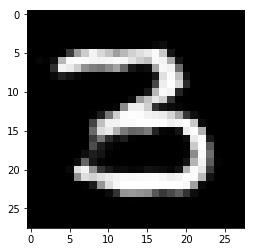

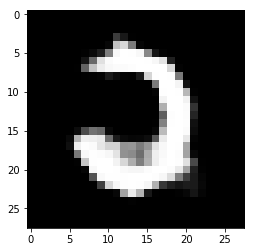

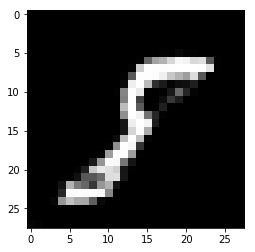

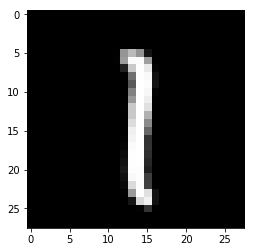

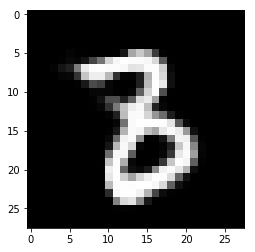

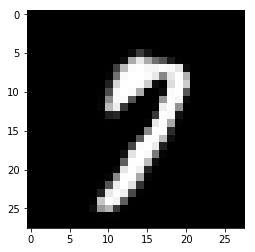

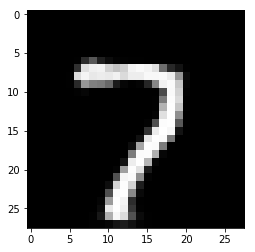

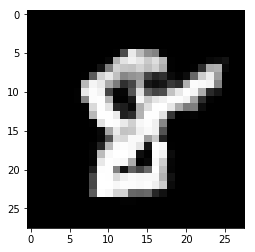

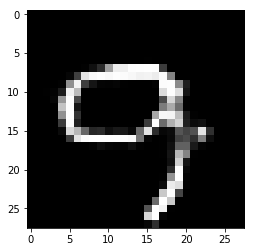

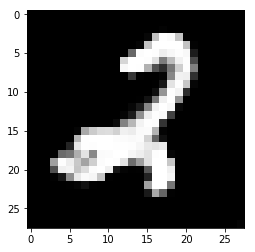

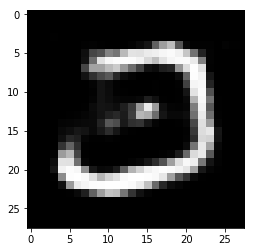

In [10]:
#Show samples
latent_vectors = np.random.normal(0.0, 1.0, [64, 100])
fake_images = generator.predict(latent_vectors)

for i in range(64):
    plt.figure(i)
    plt.imshow(fake_images[i].reshape([28, 28]), cmap='gray')

plt.show()

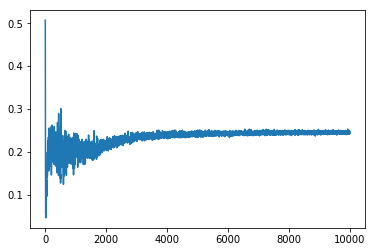

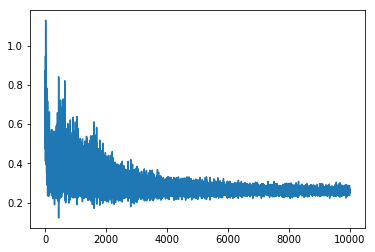

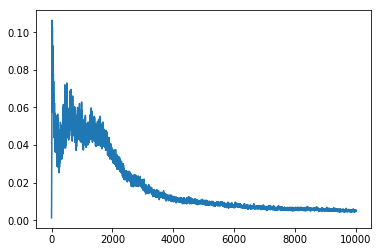

In [11]:
#Plot losses
plt.plot(d_loss)
plt.show()

plt.plot(g_loss)
plt.show()

plt.plot(gp_loss)
plt.show()